In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from Manage_data.db_manager import get_data

In [30]:
df = get_data('META', granularity='daily')
df.drop(columns=['Title'], inplace=True)
df = df.sort_values(by="Date", ascending=True)

df.head()

Adding Symbol: META
entry already exists or no title


,Date,Open,High,Low,Close,Adj_close,Volume
3213,2012-05-18,42.05,45.00,38.00,38.23,38.08,573576400
3212,2012-05-21,36.53,36.66,33.00,34.03,33.90,168192700
3211,2012-05-22,32.61,33.59,30.94,31.00,30.88,101786600
3210,2012-05-23,31.37,32.50,31.36,32.00,31.88,73600000
3209,2012-05-24,32.95,33.21,31.77,33.03,32.90,50237200


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3214 entries, 3213 to 0
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3214 non-null   datetime64[ns]
 1   Open       3214 non-null   float64       
 2   High       3214 non-null   float64       
 3   Low        3214 non-null   float64       
 4   Close      3214 non-null   float64       
 5   Adj_close  3214 non-null   float64       
 6   Volume     3214 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 200.9 KB


/tmp/ipykernel_630936/1795003646.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 100)` for the same effect.

  sns.lineplot(data=df, x=df['Open'], y=df['Close'], ci=100, sort=True, estimator='mean')


<Axes: xlabel='Open', ylabel='Close'>

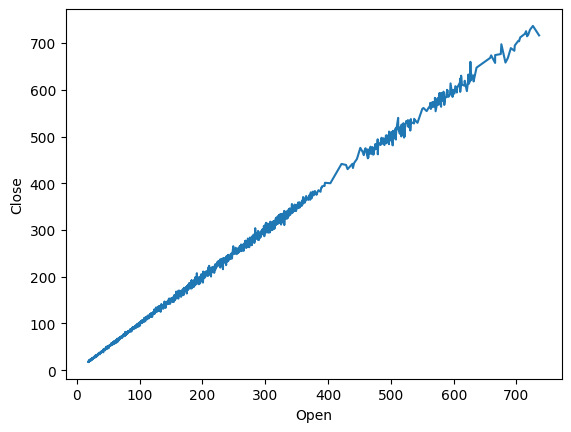

In [32]:
sns.lineplot(data=df, x=df['Open'], y=df['Close'], ci=100, sort=True, estimator='mean')

In [38]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

df_train = df['Adj_close'].values
print(df_train)

def split_data(scaled_set, train_percentage=0.8, window_size=30):
    train_end_index = int(len(scaled_set) * train_percentage)

    X_train, y_train = [], []
    for i in range(window_size, train_end_index):
        X_train.append(scaled_set[i-window_size:i])
        y_train.append(scaled_set[i])
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_test, y_test = [], []
    for i in range(train_end_index, len(scaled_set)):
        X_test.append(scaled_set[i-window_size:i])
        y_test.append(scaled_set[i])
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return X_train, y_train, X_test, y_test

def standardize_columns(df, columns):
    """
    Standardize specified columns in a DataFrame using their mean and standard deviation.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        columns (list): A list of column names to standardize.

    Returns:
        pd.DataFrame: A copy of the DataFrame with the specified columns standardized.
        dict: A dictionary containing the mean and standard deviation for each standardized column.
    """
    scaler = MinMaxScaler(feature_range= (0,1))
    df_copy = df.copy()
    df_copy[columns] = scaler.fit_transform(df[columns])
    stats = {
        col: {"mean": scaler.mean_[i], "std": scaler.scale_[i]} 
        for i, col in enumerate(columns)
    }
    return df_copy, stats

def standardize_test_data(df, columns, stats):
    """
    Standardize specified columns in a test DataFrame using the provided mean and standard deviation.

    Args:
        df (pd.DataFrame): The test DataFrame to be standardized.
        columns (list): A list of column names to standardize.
        stats (dict): A dictionary containing the mean and standard deviation for each column 
                      (from the training dataset).

    Returns:
        pd.DataFrame: A copy of the test DataFrame with the specified columns standardized.
    """
    df_copy = df.copy()
    for col in columns:
        if col not in stats:
            raise ValueError(f"Statistics for column '{col}' not found in the provided stats.")
        if col not in df_copy.columns:
            raise ValueError(f"Column '{col}' not found in the test DataFrame.")
        
        mean = stats[col]["mean"]
        std = stats[col]["std"]
        
        df_copy[col] = (df_copy[col] - mean) / std

    return df_copy


train_percentage = 0.8
X_train, y_train, X_test, y_test = split_data(df_train, train_percentage)

# Affichage des dimensions des ensembles
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


[ 38.08  33.9   30.88 ... 673.7  658.24 668.2 ]
(2541, 30)
(2541,)
(643, 30)
(643,)


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim

X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=4, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

# Initialisation du modèle
input_size = 1  
hidden_size = 50
output_size = 1

model = LSTMModel(input_size, hidden_size, output_size)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_epochs = 100
batch_size = 32

for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/100], Loss: 25441.7637
Epoch [2/100], Loss: 24213.1699
Epoch [3/100], Loss: 23105.5312
Epoch [4/100], Loss: 22063.8223
Epoch [5/100], Loss: 21073.2949
Epoch [6/100], Loss: 20127.0352
Epoch [7/100], Loss: 19221.6426
Epoch [8/100], Loss: 18353.7598
Epoch [9/100], Loss: 17521.6855
Epoch [10/100], Loss: 16723.4629
Epoch [11/100], Loss: 15957.8184
Epoch [12/100], Loss: 15223.1650
Epoch [13/100], Loss: 14518.4570
Epoch [14/100], Loss: 13842.5508
Epoch [15/100], Loss: 13194.3506
Epoch [16/100], Loss: 12572.9424
Epoch [17/100], Loss: 11977.3789
Epoch [18/100], Loss: 11406.7275
Epoch [19/100], Loss: 10860.2383
Epoch [20/100], Loss: 10336.9707
Epoch [21/100], Loss: 9836.1973
Epoch [22/100], Loss: 9357.0605
Epoch [23/100], Loss: 8898.9404
Epoch [24/100], Loss: 8461.0186
Epoch [25/100], Loss: 8042.6489
Epoch [26/100], Loss: 7643.1426
Epoch [27/100], Loss: 7261.7910
Epoch [28/100], Loss: 6898.0049
Epoch [29/100], Loss: 6551.0991
Epoch [30/100], Loss: 6220.4995
Epoch [31/100], Loss: 5905.58

Test MAE: 207.2338, Test MSE: 68650.6562


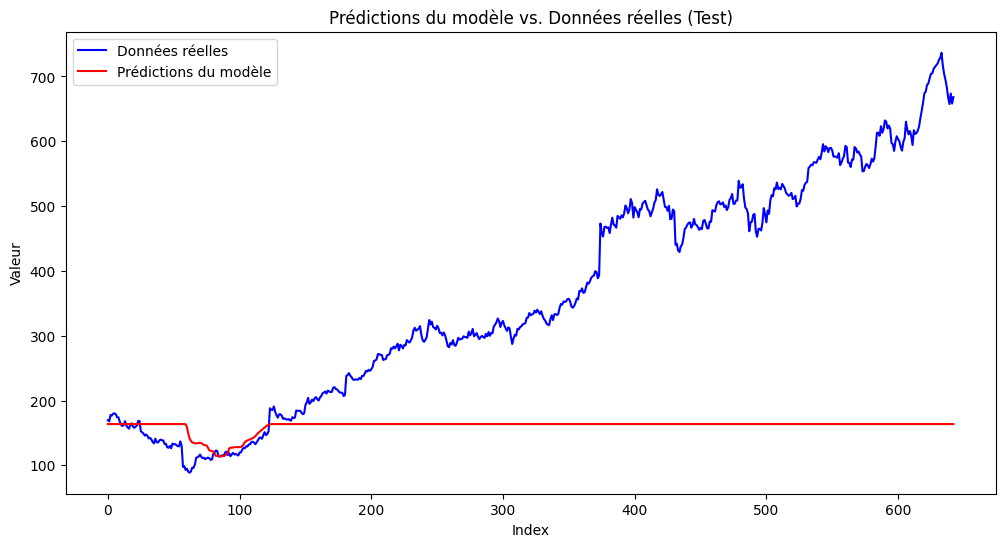

In [40]:
# Transformation des données de test en tenseurs PyTorch
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

# Évaluation sur l'ensemble de test
model.eval()
with torch.no_grad():
    test_predictions = model(X_test).cpu().numpy()
    actual_test = y_test.cpu().numpy()

    # Calculer les erreurs de performance pour les données de test
    test_mae = mean_absolute_error(actual_test, test_predictions)
    test_mse = mean_squared_error(actual_test, test_predictions)
    print(f'Test MAE: {test_mae:.4f}, Test MSE: {test_mse:.4f}')

    # Visualiser les prédictions sur les données de test
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(actual_test)), actual_test, color='blue', label='Données réelles')
    plt.plot(np.arange(len(test_predictions)), test_predictions, color='red', label='Prédictions du modèle')
    plt.title('Prédictions du modèle vs. Données réelles (Test)')
    plt.xlabel('Index')
    plt.ylabel('Valeur')
    plt.legend()
    plt.show()
